<a href="https://colab.research.google.com/github/Hyorim-Kim/numpi/blob/main/tfc18dogcat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CNN을 이용하여 개, 고양이 이미지 분류(이항분류)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
import keras

In [2]:
data_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
pathto_zip = keras.utils.get_file('cats_and_dogs.zip', origin=data_url, extract=True)
PATH = os.path.join(os.path.dirname(pathto_zip), 'cats_and_dogs_filtered')
print(PATH)

batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

# 데이터 준비
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(train_cats_dir)  # C:\Users\user\.keras\datasets\cats_and_dogs_filtered\train\cats

num_cats_dir = len(os.listdir(train_cats_dir))
num_dogs_dir = len(os.listdir(train_dogs_dir))
print(os.listdir(train_cats_dir)[:5])  # ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg']
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_dir + num_dogs_dir
total_val = num_cats_val + num_dogs_val

print('total_train cat : ', num_cats_dir)
print('total_train dog : ', num_dogs_dir)
print('total_validation cat : ', num_cats_val)
print('total_validation  dog: ', num_dogs_val)
print('total_train : ', total_train)  # 2000
print('total_val : ', total_val)  # 1000


/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
['cat.872.jpg', 'cat.887.jpg', 'cat.619.jpg', 'cat.525.jpg', 'cat.290.jpg']
total_train cat :  1000
total_train dog :  1000
total_validation cat :  500
total_validation  dog:  500
total_train :  2000
total_val :  1000


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
(128, 150, 150, 3)   (128,)
1.0 1.0


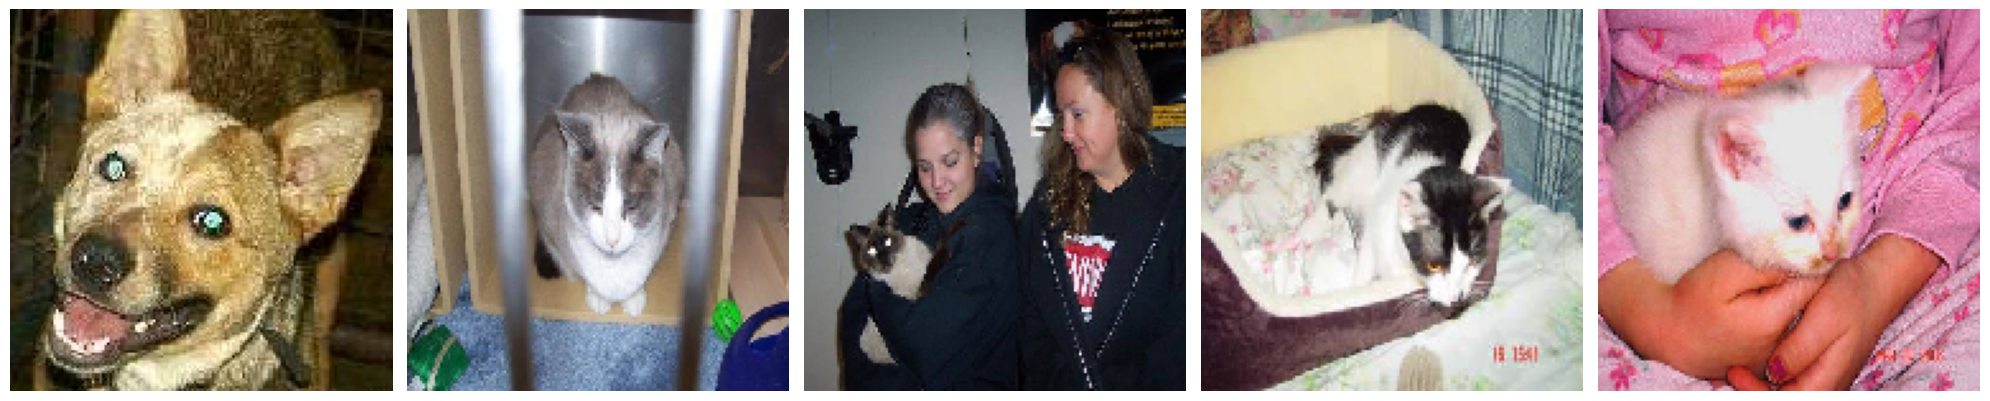

In [3]:
# 데이터를 실수 타입의 텐서로 전처리
# 두 개의 이미지에 대한 라벨링
train_image_gen = ImageDataGenerator(rescale=1./255)
validation_image_gen = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_gen.flow_from_directory(directory=train_dir, batch_size=batch_size, shuffle=True,
                                                                                                target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary')  # (128, 150, 150, 3)
val_data_gen = validation_image_gen.flow_from_directory(directory=validation_dir, batch_size=batch_size, shuffle=True,
                                                                                                      target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary')  # (128,)
# flow_from_directory는 배치를 무한정 만들어 내므로 break를 해주는 것이 바람직
for a, b in train_data_gen:
  print(a.shape, ' ', b.shape)  # (128, 150, 150, 3)   (128,)
  print(b[0], b[1])
  break
for a, b in val_data_gen:
  break

# 데이터 확인
sample_training_images, _ = next(train_data_gen)

def plotImage(img_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(img_arr, axes):
    ax.axis('off')
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

plotImage(sample_training_images[:5])
# print(sample_training_images[:1])  # [[[[0.04705883 0.04705883 0.05490196]


In [4]:
# 모델
model = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(rate=0.2),
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(rate=0.2),
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(rate=0.2),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])  # 텐서를 logits으로 처리할지 - 수치적으로 안정적
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 75, 75, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 32)        0

In [5]:
# 학습
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

model.save('cat_dog.keras')


<ipython-input-5-c01410d9ba76>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/15
15/15 [==============================] - 20s 463ms/step - loss: 0.8052 - accuracy: 0.4957 - val_loss: 0.6936 - val_accuracy: 0.5045
Epoch 2/15
15/15 [==============================] - 5s 352ms/step - loss: 0.6925 - accuracy: 0.5037 - val_loss: 0.6916 - val_accuracy: 0.5022
Epoch 3/15
15/15 [==============================] - 6s 409ms/step - loss: 0.6909 - accuracy: 0.4931 - val_loss: 0.6874 - val_accuracy: 0.4922
Epoch 4/15
15/15 [==============================] - 6s 415ms/step - loss: 0.6870 - accuracy: 0.5048 - val_loss: 0.6861 - val_accuracy: 0.4922
Epoch 5/15
15/15 [==============================] - 6s 438ms/step - loss: 0.6727 - accuracy: 0.5288 - val_loss: 0.6567 - val_accuracy: 0.5804
Epoch 6/15
15/15 [==============================] - 6s 412ms/step - loss: 0.6500 - accuracy: 0.5769 - val_loss: 0.6423 - val_accuracy: 0.5871
Epoch 7/15
15/15 [==============================] - 6s 433ms/step - loss: 0.6627 - accuracy: 0.5716 - val_loss: 0.6631 - val_accuracy: 0.5614
Epoch

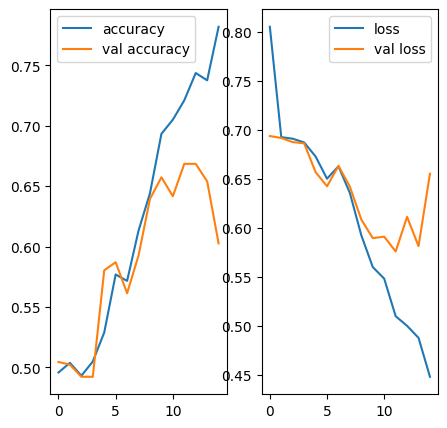

In [6]:
# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='accuracy')
plt.plot(epochs_range, val_acc, label='val accuracy')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='loss')
plt.plot(epochs_range, val_loss, label='val loss')
plt.legend(loc='best')
plt.show()

In [12]:
# 새로운 이미지 분류
import numpy as np
from google.colab import files
import tensorflow as tf

mymodel = tf.keras.models.load_model('cat_dog.keras')
uploaded = files.upload()
print(uploaded.keys())

for fn in uploaded.keys():
  path = '/content/' + fn
  img = tf.keras.utils.load_img(path, target_size=(150, 150))
  x = tf.keras.utils.img_to_array(img)
  print(x.shape)  # (150, 150, 3)
  x = np.expand_dims(x, axis=0)
  print(x.shape)  # (1, 150, 150, 3)
  images = np.vstack([x])
  classes = mymodel.predict(images, batch_size=10)
  print(classes)
  print(classes[0])

  if classes[0] > 0:
    print(fn + '은 댕댕이')
  else:
    print(fn + '은 냐옹이')

Saving animal2.jpg to animal2.jpg
dict_keys(['animal2.jpg'])
(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 119ms/step
[[260.21222]]
[260.21222]
animal2.jpg은 댕댕이
